In [1]:
import torch
from torch import nn
import torch.utils.data as Data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from model import Classifier
from preprocessing import Create_Matrix, StandardScaler, Split

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [2]:
timesteps = 90
batch_size = 512
epochs = 400

In [3]:
sample = pd.read_csv('bdi.csv', parse_dates=['date'], index_col=['date']).fillna(method='ffill').values

In [4]:
label=[0]
for i in range(sample.shape[0]-1):
    if sample[i] < sample[i+1]:
        label.append(1)
    else:
        label.append(0)

In [5]:
x = np.array([sample[i-15:i] for i in range(15, len(sample))])
x = np.array([x[i-76:i] for i in range(76, len(x)+1)]).reshape(-1, 76, 1, 15)
y = np.array([label[i] for i in range(90, len(label))]).reshape(-1, 1)

In [6]:
x_train, y_train, x_val, y_val, x_test, y_test = Split(x, y)

In [7]:
train = pd.DataFrame(columns=(['chance']), data=y_train) 
train.to_csv('train.csv', index=False, header=True)

In [8]:
scaler = StandardScaler(x_train.reshape(-1))
x_train = scaler.transform(x_train)
x_val = scaler.transform(x_val)
x_test = scaler.transform(x_test)

In [9]:
x_train = torch.FloatTensor(x_train).to(device)
y_train = torch.FloatTensor(y_train).to(device)
x_val = torch.FloatTensor(x_val).to(device)
y_val = torch.FloatTensor(y_val).to(device)
x_test = torch.FloatTensor(x_test).to(device)

In [10]:
dataset = Data.TensorDataset(x_train, y_train)
dataloader = Data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)

In [11]:
model = Classifier().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.BCELoss()

In [12]:
history = dict()
history['loss'] = []
history['val_loss'] = []
best_model = np.inf
for epoch in range(epochs):
    for x_batch, y_batch in dataloader:
        model.train()
        y_pred = model(x_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    with torch.no_grad():
        model.eval()
        y_pred = model(x_val)
        val_loss = criterion(y_pred, y_val)
        loss = loss.item()
        val_loss = val_loss.item()
    print(f'Epoch:{1+epoch:03d}-loss:{loss:.5f}-val_loss:{val_loss:.5f}')
    if val_loss <= best_model:
        best_model = val_loss
        torch.save(model, 'checkpoint.pt')
        print('weight_saved')
    history['loss'].append(loss)
    history['val_loss'].append(val_loss)
model = torch.load('checkpoint.pt')

Epoch:001-loss:0.65435-val_loss:0.64223
weight_saved
Epoch:002-loss:0.64229-val_loss:0.64229
Epoch:003-loss:0.65762-val_loss:0.64177
weight_saved
Epoch:004-loss:0.64075-val_loss:0.64413
Epoch:005-loss:0.59937-val_loss:0.64221
Epoch:006-loss:0.62855-val_loss:0.64099
weight_saved
Epoch:007-loss:0.61623-val_loss:0.64826
Epoch:008-loss:0.60945-val_loss:0.64068
weight_saved
Epoch:009-loss:0.60715-val_loss:0.63914
weight_saved
Epoch:010-loss:0.61165-val_loss:0.65409
Epoch:011-loss:0.60771-val_loss:0.62232
weight_saved
Epoch:012-loss:0.62667-val_loss:0.62654
Epoch:013-loss:0.61169-val_loss:0.62784
Epoch:014-loss:0.56771-val_loss:0.60663
weight_saved
Epoch:015-loss:0.59749-val_loss:0.63661
Epoch:016-loss:0.62204-val_loss:0.60038
weight_saved
Epoch:017-loss:0.57641-val_loss:0.60091
Epoch:018-loss:0.59141-val_loss:0.60136
Epoch:019-loss:0.57103-val_loss:0.60327
Epoch:020-loss:0.55621-val_loss:0.58959
weight_saved
Epoch:021-loss:0.54515-val_loss:0.59917
Epoch:022-loss:0.56591-val_loss:0.59086
Epo

Epoch:200-loss:0.37493-val_loss:0.52878
Epoch:201-loss:0.36353-val_loss:0.49132
Epoch:202-loss:0.36514-val_loss:0.48156
Epoch:203-loss:0.34698-val_loss:0.48532
Epoch:204-loss:0.31271-val_loss:0.48712
Epoch:205-loss:0.36921-val_loss:0.51137
Epoch:206-loss:0.30281-val_loss:0.50545
Epoch:207-loss:0.55888-val_loss:0.71033
Epoch:208-loss:0.41698-val_loss:0.56947
Epoch:209-loss:0.40997-val_loss:0.51293
Epoch:210-loss:0.44265-val_loss:0.54999
Epoch:211-loss:0.41387-val_loss:0.48640
Epoch:212-loss:0.36433-val_loss:0.49736
Epoch:213-loss:0.37051-val_loss:0.53878
Epoch:214-loss:0.38889-val_loss:0.50544
Epoch:215-loss:0.41493-val_loss:0.48323
Epoch:216-loss:0.34809-val_loss:0.47450
Epoch:217-loss:0.30785-val_loss:0.48117
Epoch:218-loss:0.38918-val_loss:0.54260
Epoch:219-loss:0.31707-val_loss:0.48067
Epoch:220-loss:0.31587-val_loss:0.52387
Epoch:221-loss:0.39891-val_loss:0.54598
Epoch:222-loss:0.35706-val_loss:0.53578
Epoch:223-loss:0.35451-val_loss:0.47826
Epoch:224-loss:0.43937-val_loss:0.53605


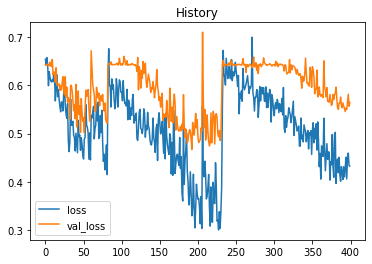

In [13]:
plt.plot(history['loss'], label='loss')
plt.plot(history['val_loss'], label='val_loss')
plt.title('History')
plt.legend()
plt.show()

In [14]:
with torch.no_grad():
    model.eval()
    pred = model(x_test)
    pred = pred.cpu().numpy()
test = []
for i in pred:
    if i < 0.5:
        test.append(0)
    else:
        test.append(1)
metrics.accuracy_score(y_test, test)

0.764

In [15]:
with torch.no_grad():
    model.eval()
    pred = model(x_val)
    pred = pred.cpu().numpy()
val = []
for i in pred:
    if i < 0.5:
        val.append(0)
    else:
        val.append(1)

In [16]:
val = pd.DataFrame(columns=(['chance']), data=val) 
val.to_csv('val.csv', index=False, header=True)
test = pd.DataFrame(columns=(['chance']), data=test) 
test.to_csv('test.csv', index=False, header=True)